In [129]:
%matplotlib inline

In [130]:
# from __future__ import print_function
import time
import numpy as np
import argparse
import io
import os
import sys
import datetime
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import animation
import matplotlib.gridspec as gridspec
from mpl_toolkits import mplot3d
from uncertainties import unumpy
import uncertainties as u
import itertools
import ucert
import seaborn as sns
import pandas as pd
from tqdm import tqdm

#### Initial Config

##### This segment will be setting initial color schemes and building mappings for heatmaps

In [131]:
experiment = '/Users/TRD/Research_Personal/Quant_Mo/data/aw_motion/'
data = experiment + 'data'
pickled = experiment + 'pickled'
photos = experiment + 'photos'
day = 'final'
color1 = '#bf5700'
color2 = '#808080'
rgb_color1 = mpl.colors.to_rgb(color1)
rgb_color2 = mpl.colors.to_rgb(color2)
my_cmap = mpl.colors.LinearSegmentedColormap.from_list('my_cmap', [rgb_color1, rgb_color2], N=100)

##### SETUP PROCESS - BUILDS DIRECTORY STRUCTURE

In [132]:
if os.path.exists(pickled) is False:
    os.makedirs(pickled)
if os.path.exists(photos) is False:
    os.makedirs(photos)

In [133]:
plt.rcParams['figure.figsize'] = [13, 9]

#### Main Functions
-  main processing function which rebuilds the data into this system
-  edging function to remove heavy bias
-  normalization function

In [134]:
def process(file):
    numObj = np.load(file)
    [date, arr] = numObj
    return [date, arr]

In [135]:
def pythag(arr):
    # This is going to reduce the system into one array ~ ideally ~ a mxm matrix of rank 2
    finalArr = np.zeros(arr.shape[:-1],dtype='float32')
    for i in range(arr.shape[-1]):
        finalArr += np.power(arr[...,i], 2)
    return np.power(finalArr, 0.5)

In [136]:
def edge(arr, scope):
    if len(scope) == 2:
        lowerBound_x = lowerBound_y = scope[0]
        upperBound_x = upperBound_y = scope[1]
    elif len(scope) == 4:
        lowerBound_x = scope[0]; lowerBound_y = scope[2]
        upperBound_x = scope[1]; upperBound_y = scope[3]
    else: return None
    x_ = arr.shape[0]; y_ = arr.shape[1]
    return arr[int(x_*lowerBound_x):int(x_*upperBound_x),int(y_*lowerBound_y):int(y_*upperBound_y),:]

In [137]:
def gradient(array): return np.gradient(array) #np.add.reduce(np.gradient(array))

In [138]:
def importMatrix(file):
    num_cols = 2
    converters = dict.fromkeys(
        range(num_cols),
        lambda col_bytes: u.ufloat_fromstr(col_bytes.decode("latin1")))
    arr = np.loadtxt(file, converters=converters, dtype=object)
    return arr.reshape((64,64,2))

In [139]:
# Shouldn't really be needed
def normalize(x):
    return x/np.amax(np.absolute(x))

In [140]:
def intensity(x):
    # This is taking the hypotenuse of the intensity vectors
    assert type(x).__module__ == np.__name__
    return np.power(np.sum(np.power(x,2),axis=len(x.shape)-1),0.5) # pythagorean

In [141]:
A = np.load(day+'.npy')

In [142]:
A = edge(A, (0.2, 0.74))

This function is looking to take something with an X and Y system to decompose it into a collapsed major system

In [143]:
# A = pythag(A)

This function yields the gradient (velocities at each given point within the graph - it's in experimental mode at the moment and prone to failure as it changes the dimensions of the matrix)

0.4243


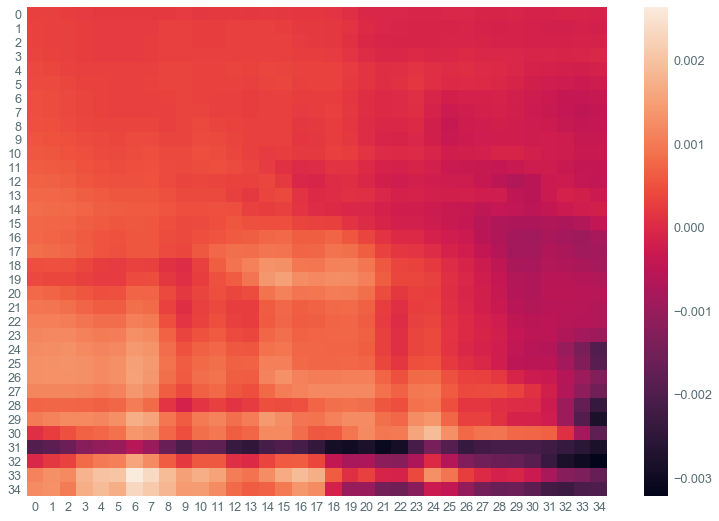

In [144]:
Gx, Gy, Gz = np.gradient(A)
thing = pd.DataFrame(Gz[...,0])
sns.heatmap(data=thing)
divergence = np.sum((Gx, Gy, Gz))
print(divergence)

This code block underneath will normalize any matrix, showing relative weight between the matrices

In [145]:
print(A.shape)

(35, 35, 2)


In [146]:
A = normalize(A)

In [147]:
def floaty(*args):
    ret = []
    for i in args:
        if type(i) is np.ndarray: 
            ret.append(i.astype('float64'))
        else:
            raise ValueError
    return ret

#### Analysis
-  Primary look is with the aveerage motion across a segment of the array
-  Secondary is taylor series fit and fourier analysis
-  Third is brief display of quality of fit vs taylor size
-  Fourth is motion vector display
-  Fifth, sixth, seventh are gradient display (i.e. proportional to the "force")

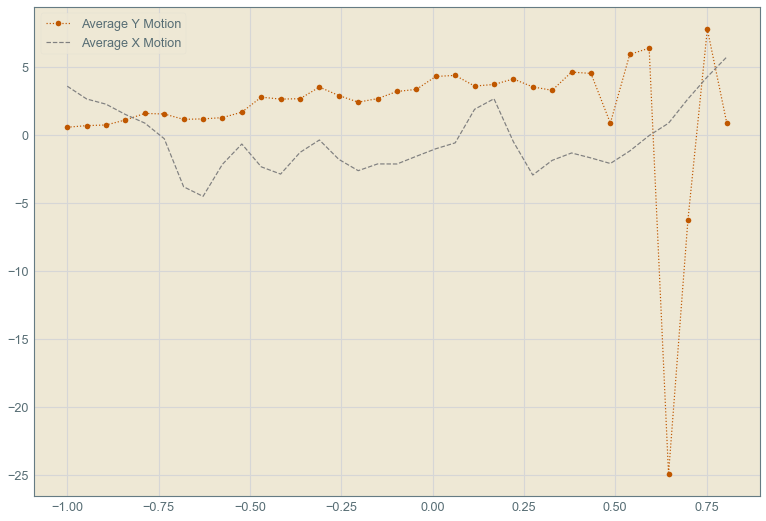

In [148]:
import matplotlib.pyplot as plt
X = np.linspace(np.min(A),np.max(A),num=A.shape[0])
y_motion = A[...,1]; x_motion = A[...,0];
y_avg = np.sum(y_motion, axis=1)
x_avg = np.sum(x_motion, axis=0)
max_val = np.max(y_motion.shape); min_val = 0
content = [X, y_avg, x_avg]
[X, y_avg, x_avg] = floaty(*content)
plt.plot(X,y_avg,'o:', color=color1, label="Average Y Motion")
plt.plot(X,x_avg,'--', color=color2, label="Average X Motion")
plt.legend(loc='best')
plt.show()

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:28: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


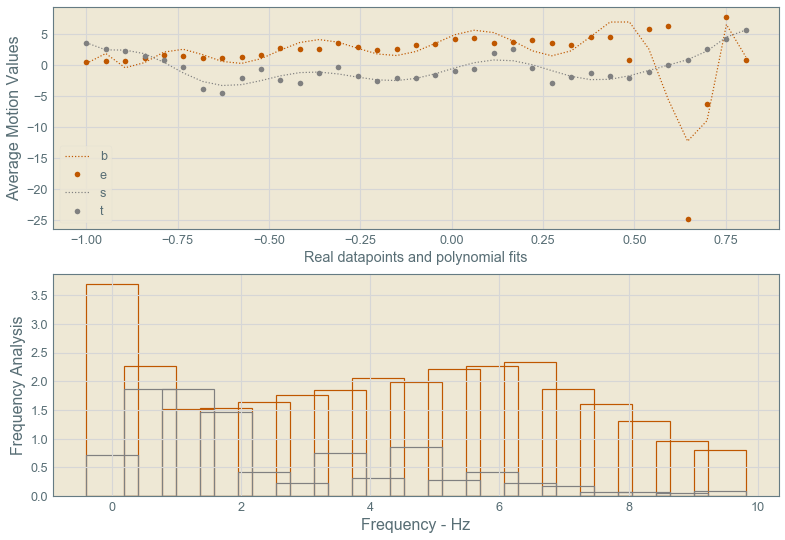

In [149]:
gs = gridspec.GridSpec(2,1, hspace=0.2)
fig = plt.figure()

poly_fit = 12
Vy = np.polyfit(X,y_avg,poly_fit)
Py = np.poly1d(Vy)
Vx = np.polyfit(X,x_avg,poly_fit)
Px = np.poly1d(Vx)

if y_avg.size == x_avg.size:
    N = y_avg.size;
else:
    raise

t = X[1]-X[0];

#first plot
ax = fig.add_subplot(gs[0])
ax.plot(X,Py(X),":", color=color1, label='Polyfit Terms'); ax.plot(X,y_avg,'o',color=color1, label="Average Motion Terms")
ax.plot(X,Px(X),":", color=color2, label='Polyfit Terms'); ax.plot(X,x_avg,'o',color=color2, label="Average Motion Terms")
ax.set_ylabel(r'Average Motion Values', size =16)
ax.set_xlabel(r'Real datapoints and polynomial fits')
ax.legend('best')

#second plot
ax = fig.add_subplot(gs[1])
fft_y = np.fft.fft(y_avg); fft_x = np.fft.fft(x_avg);
f = np.linspace(0.0, 1.0/(2.0*t), N/2)
ax.bar(f[:N], np.abs(fft_y)[:N // 2] * (2.0 / N), color=color1, fill=False, edgecolor=color1, linewidth=1.2)
ax.bar(f[:N], np.abs(fft_x)[:N // 2] * (2.0 / N), color=color2, fill=False, edgecolor=color2, linewidth=1.2)
ax.set_ylabel(r'Frequency Analysis', size =16)
ax.set_xlabel(r'Frequency - Hz', size =16)

plt.show()

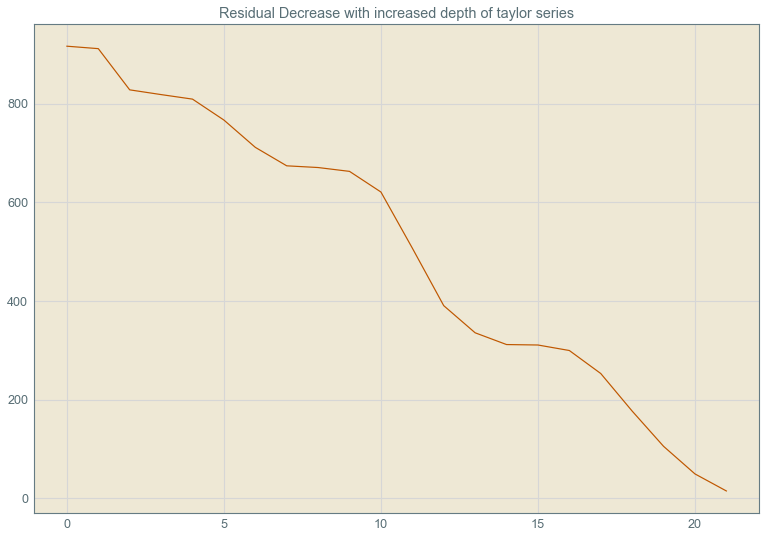

In [150]:
residuals = []
test_range = 22
for i in range(test_range):
    Vy, residual, rank, singular_values, rcond = np.polyfit(X,y_avg,i,full=True)
    residuals.append(residual)
    
R = np.array(residuals)
R = R.flatten()
X_vals = np.array(range(test_range))
plt.plot(X_vals, R, color=color1)
plt.title("Residual Decrease with increased depth of taylor series")
plt.show()

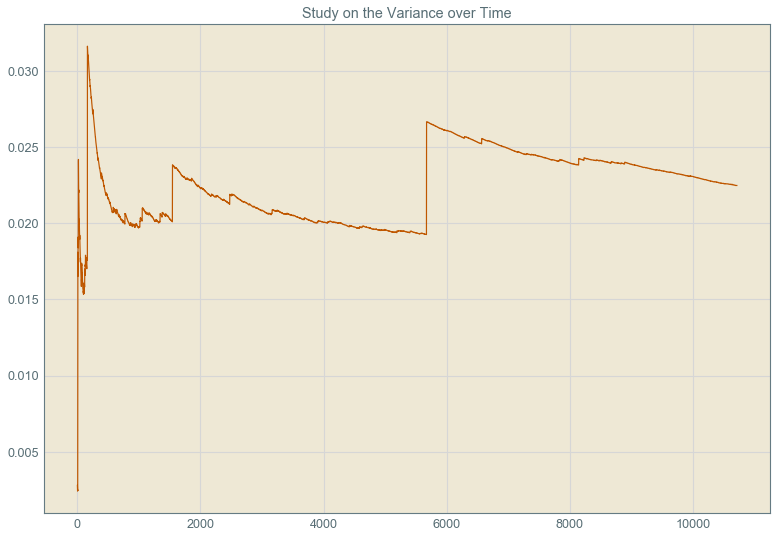

In [151]:
## This is a study on the variance over time of the system
var_evo = np.load(day+'_var.npy')
plt.plot(var_evo, color=color1)
plt.title("Study on the Variance over Time")
plt.show()

In [152]:
print(A.shape)

(35, 35, 2)


In [153]:
heat_x = np.linspace(np.min(A[0,...]), np.max(A[0,...]), num=A.shape[0])
heat_y = np.linspace(np.min(A[1,...]), np.max(A[1,...]), num=A.shape[1])
XX,YY = np.meshgrid(heat_x,heat_y)
#plt.quiver(A[...,0],A[...,1], color='#bf5700', pivot='mid')
#plt.title("Motion in X and Y")
#sns.jointplot(A[0,...], kind="hex", color="#4CB391")
plt.show()

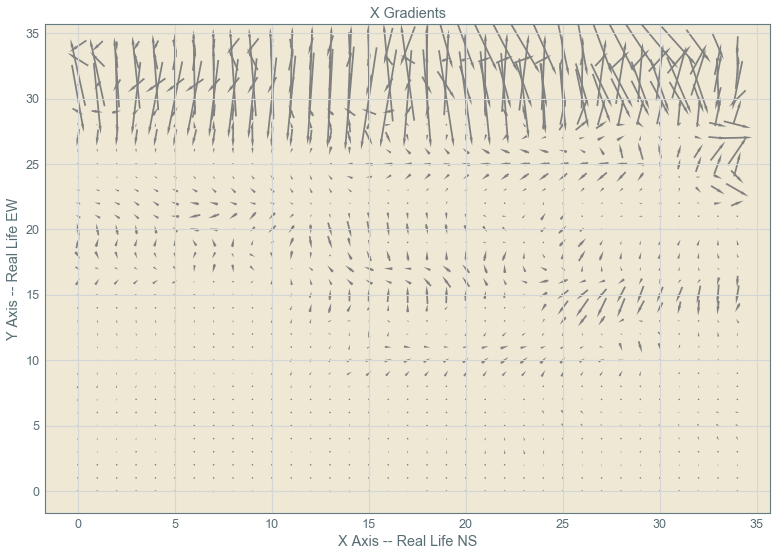

In [154]:
plt.quiver(Gx[...,0] ,Gx[...,1], color=color2, pivot='mid', headwidth=1.8)
plt.title("X Gradients")
plt.ylabel("Y Axis -- Real Life EW")
plt.xlabel("X Axis -- Real Life NS")
plt.show()

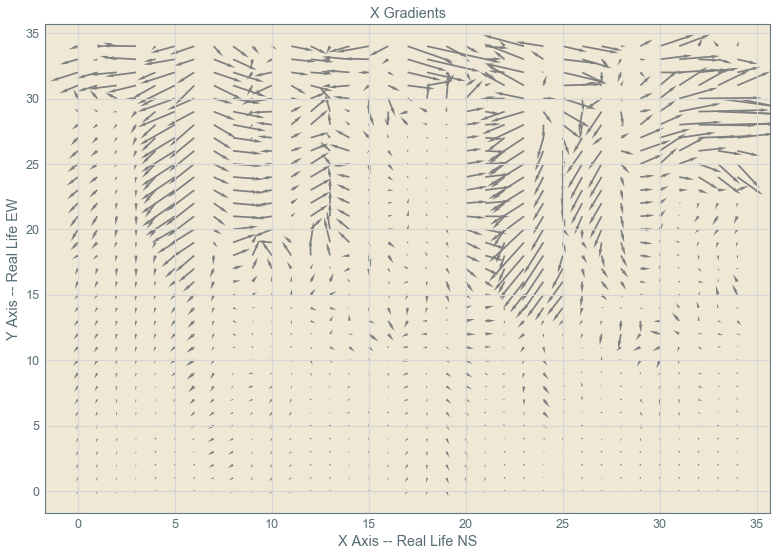

In [155]:
plt.quiver(Gy[...,0] ,Gy[...,1], color=color2, headwidth=2)
plt.title("X Gradients")
plt.ylabel("Y Axis -- Real Life EW")
plt.xlabel("X Axis -- Real Life NS")
plt.show()

[191  87   0]


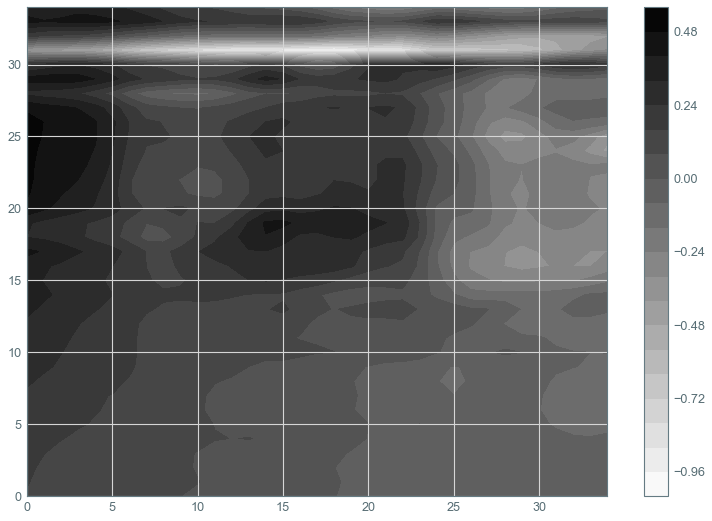

In [156]:
plt.contourf(A[...,1], 20, cmap='binary');
plt.colorbar();
rgb_color1 = (255*np.array(mpl.colors.to_rgb(color1))).astype('int')
print(rgb_color1)

##### Now we're going to think for a bit about how the data evolves over time

In [157]:
def proc(file):     
    numObj = np.load(file)
    [date, arr] = numObj
    A = unumpy.matrix(arr.flatten())
    # this SHOULD build a new array that's twice as big -
    # but everything is float values instead of strings (yay) and alternates
    # between nominal, std, nominal, std
    A_nom = np.ravel(A.nominal_values)
    outArr = np.reshape(A_nom, arr.shape)
    return [date, outArr]

In [158]:
print(motion_files[10])

aw_motion!6@2018-09-08.11:04:13.npy


In [88]:
arr = ['Date', 'X','Motion']
cols = list(range(10))
arr.append(cols)
flattened = []
for i in arr:
    if i is type(str):
        flattened = flattened.append(i)
    elif i is type(list):
        for j in i:
            flattened = flattened.append(j)

print(flattened)

[]


In [128]:
lt_motion = pd.DataFrame([])
arr = ['Date','X','Y','xy','m']
lt_motion = pd.DataFrame(columns=arr)
for root, dirs, files in os.walk(data):
    motion_files = files

#print(lt_motion)
for c,i in enumerate(motion_files[0:50]):
    mot = proc(data+'/'+i) #opens the data
    x, y, z = mot[1].shape # Gives us the shape of the object
    mot_date =  pd.to_datetime(mot[0], format='%Y-%m-%d %H:%M:%S.%f') # Gives us the dateimte
    for i in range(x):
        for j in range(y):
            for k in range(z):
                lt_motion.loc[c*x*y*z+i*y*z+j*y+k] = [mot_date,i,j,k,mot[1][i][j][k]]

In [127]:
print(sys.getsizeof(lt_motion)/1000000.0)

0.214744


/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


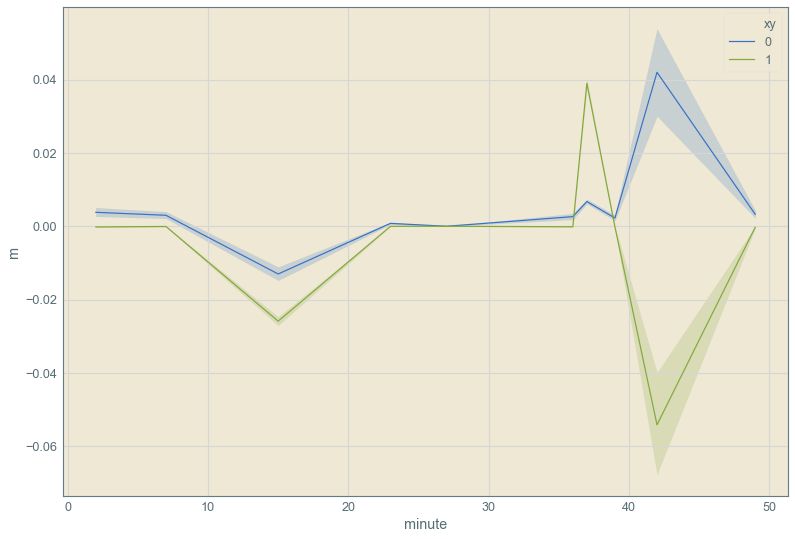

In [116]:
lt_motion['minute'] = pd.DatetimeIndex(lt_motion['Date']).minute
sns.lineplot(x='minute',y='m',hue='xy',data=lt_motion)

/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


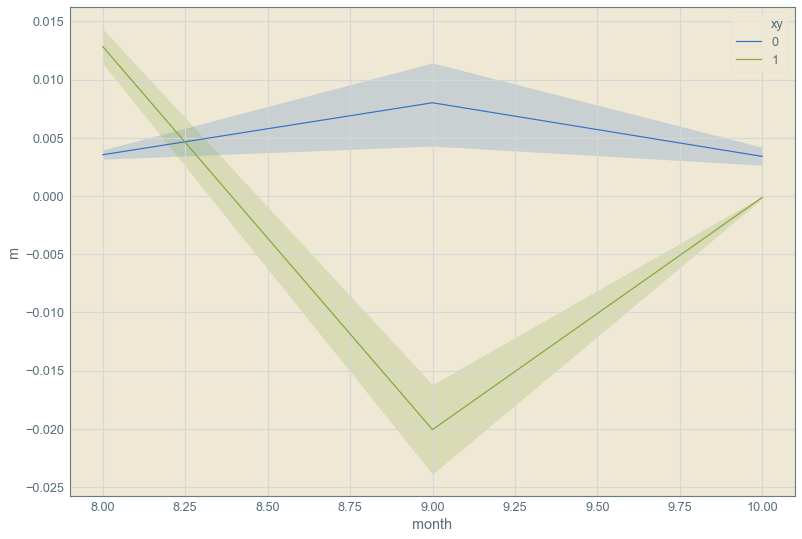

In [120]:
lt_motion['month'] = pd.DatetimeIndex(lt_motion['Date']).month
sns.lineplot(x='month',y='m',hue='xy',data=lt_motion)

/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


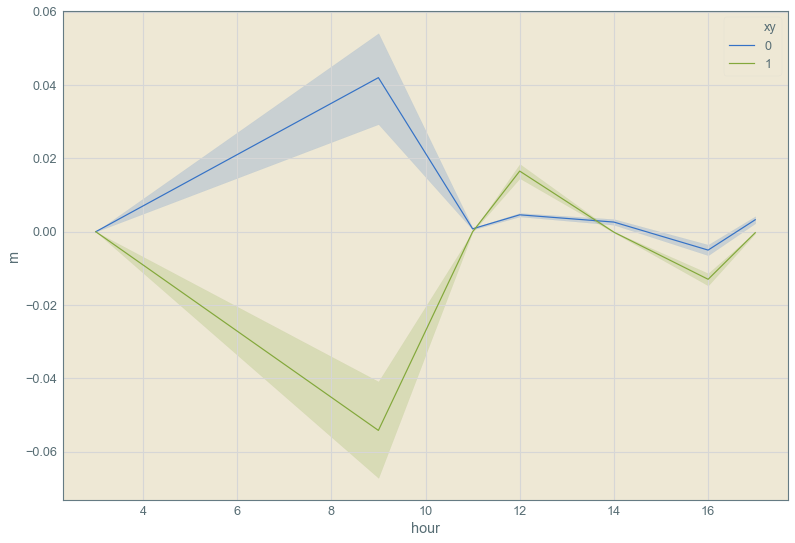

In [125]:
lt_motion['hour'] = pd.DatetimeIndex(lt_motion['Date']).hour
sns.lineplot(x='hour',y='m',hue='xy',data=lt_motion)

In [45]:
thingo = pd.read_pickle('lt_motion.pkl')
print(thingo.head())

  Date    X    Y Motion                                                  0  \
0  NaN  NaN  NaN    NaN                         2018-10-04 16:07:22.554320   
1  NaN  NaN  NaN    NaN                                                  1   
2  NaN  NaN  NaN    NaN                                                  0   
3  NaN  NaN  NaN    NaN  [0.0029833203360505323, 0.0030149009567228546,...   

                                                   1  \
0                         2018-10-04 16:07:22.554320   
1                                                  0   
2                                                  1   
3  [-2.634891450625787e-05, -8.489925333510229e-0...   

                                                   2  \
0                         2018-08-14 03:27:19.021641   
1                                                  1   
2                                                  0   
3  [2.8033435771709523e-10, 1.5737473015020858e-1...   

                                               